/Users/guochaosun/Desktop/simstack_py/catalogs/uds8.csv
Size Read-In:  (81249, 4)
Size Filtered:  (81126, 4)


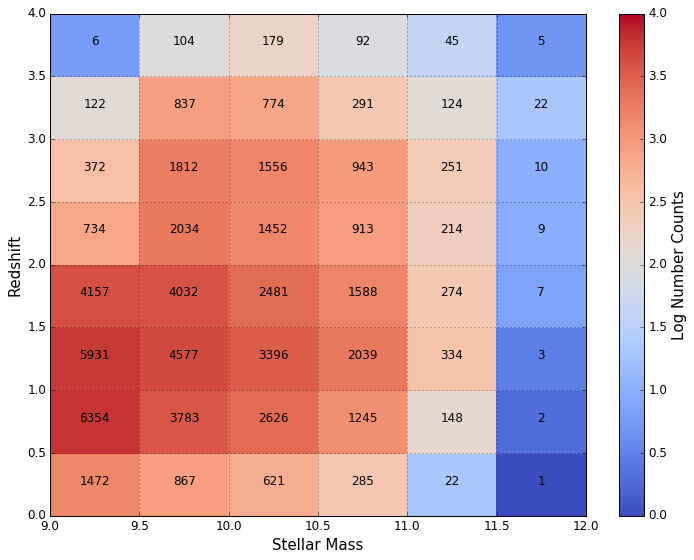

Size Read-In:  (81249, 4)
Size Filtered:  (81126, 4)
3.4
3.3
t_factor = 1.25


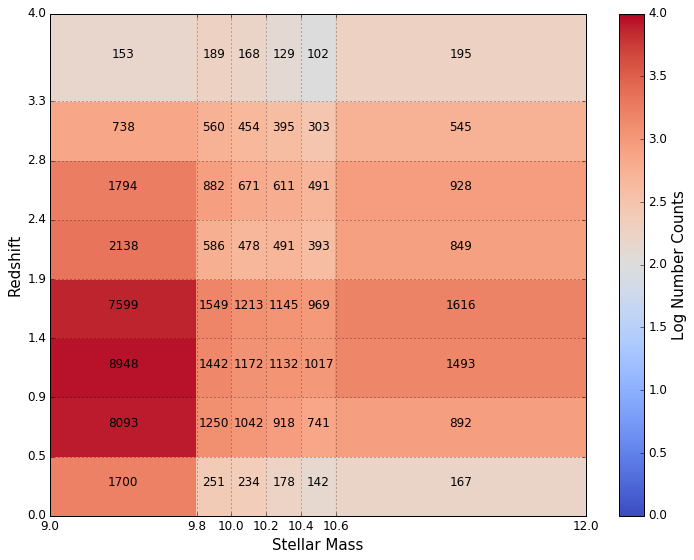

Assigned 1700 sources to the 1 th binned catalog.
Assigned 8093 sources to the 2 th binned catalog.
Assigned 8948 sources to the 3 th binned catalog.
Assigned 7599 sources to the 4 th binned catalog.
Assigned 2138 sources to the 5 th binned catalog.
Assigned 1794 sources to the 6 th binned catalog.
Assigned 738 sources to the 7 th binned catalog.
Assigned 153 sources to the 8 th binned catalog.
Assigned 251 sources to the 9 th binned catalog.
Assigned 1250 sources to the 10 th binned catalog.
Assigned 1442 sources to the 11 th binned catalog.
Assigned 1549 sources to the 12 th binned catalog.
Assigned 586 sources to the 13 th binned catalog.
Assigned 882 sources to the 14 th binned catalog.
Assigned 560 sources to the 15 th binned catalog.
Assigned 189 sources to the 16 th binned catalog.
Assigned 234 sources to the 17 th binned catalog.
Assigned 1042 sources to the 18 th binned catalog.
Assigned 1172 sources to the 19 th binned catalog.
Assigned 1213 sources to the 20 th binned catalo

0

In [5]:
import numpy as np
from numpy import linspace, logspace
from scipy.integrate import quad
import scipy.optimize as optimize
import os as _os
import pandas as pd
import matplotlib.pylab as plt
from cosmology import *

%matplotlib inline

# Get the path of the master catalog file
_HOME = _os.environ.get('HOME')

#path_cat = '/Desktop/simstack_py/catalogs/test_cat_0.csv'
path_cat = '/Desktop/simstack_py/catalogs/uds8.csv'
path_cat = _HOME + path_cat

print path_cat



def Check_Monotonicity(L):
    return all(x<y for x, y in zip(L, L[1:]))


def Error_Msg(err_type):
    if err_type == 'ImproperBinSize':
        return "Too many bins for the given N_gal_thres. Try smaller integers for 'N_mbins', 'N_zbins' and 'N_gal_thres'"
    elif err_type == 'InvalidMassScale':
        return " is not a valid mass scale. Use 'log' or 'linear'."
    elif err_type == 'InvalidTimeScale':
        return " is not a valid time scale. Use 'redshift' or 'lookback_time'."


def Plot_Grid(X, Y, Z, z_min, z_max):
    ''' Plot the binning in a 2D grid '''
    # Get log number counts
    log10_Z = np.log10(Z)
    barvs = linspace(z_min,z_max,9)
    
    text_xs = (X[0:-1]+X[1::])/2.
    text_ys = (Y[0:-1]+Y[1::])/2.
    plt.figure(figsize=(12,9))
    plt.pcolor(X, Y, log10_Z, cmap='coolwarm', vmin=0.0, vmax=4.0)
    for i in range(0,text_xs.shape[0]):
        for j in range(0,text_ys.shape[0]):
            plt.text(text_xs[i],text_ys[j],str(int(Z[j,i])),ha='center',fontsize=12)
    plt.xticks(X, np.round(X,1), fontsize=12)
    plt.yticks(Y, np.round(Y,1), fontsize=12)
    plt.xlabel('Stellar Mass', fontsize=15)
    plt.ylabel('Redshift', fontsize=15)
    plt.ylim([z_min,z_max])
    cb = plt.colorbar(ticks=barvs)
    cb.ax.tick_params(labelsize=12)
    cb.set_label('Log Number Counts', fontsize=15)
    plt.grid(True)
    plt.show() 
    
    return 0


def Assign_M_Bounds(array1D,m_scale): 
    _min = min(array1D); _max = max(array1D)
    _lb = np.maximum(int(_min/0.5)*0.5,9.0)
    _ub = np.minimum(int(_max/0.5+0.5)*0.5,12.0)
    return [_lb, _ub]


def Prelim_Binning(col_to_read,z_scale,m_scale,N_mbins,N_zbins,N_gal_thres,Ms_min,Ms_max,
            z_min,z_max,fixed_bounds):
    
    df_cat_in = pd.read_csv(path_cat,usecols=col_to_read)
    header_list = list(df_cat_in.columns.values)
    
    cat_in = df_cat_in.as_matrix(columns=df_cat_in.columns)
    n_sources = cat_in.shape[0]; n_params = cat_in.shape[1]
    print 'Size Read-In: ', cat_in.shape
    # Discard rows w/o M* and/or z_peak values
    ind_valid = np.ones((n_sources,), dtype=np.int)
    for j in range(2,n_params):
        ind_valid = ind_valid-np.isnan(cat_in[:,j])
    # Discard rows with faulty M* (i.e. M* not in [5.0,14.0])
    ind_valid = ind_valid - ((cat_in[:,3]<5.0) + (cat_in[:,3]>14.0))
    # Get the indices of filtered rows 
    ind_valid = np.where(ind_valid)[0]
    
    # Update the size of the input catalog
    cat_in = cat_in[ind_valid,:]
    print 'Size Filtered: ', cat_in.shape
    n_sources = cat_in.shape[0]; n_params = cat_in.shape[1]
    
    
    # ==========   Get mass binning first   ========== #
    
    ### Separate the RA, DEC, mass and redshift columns ###
    RA_index = header_list.index('RA')
    DEC_index = header_list.index('DEC')
    m_index = header_list.index('mass')
    z_index = header_list.index('z_peak')
    
    RA_column = cat_in[:,RA_index]
    DEC_column = cat_in[:,DEC_index]
    m_column = cat_in[:,m_index]
    z_column = cat_in[:,z_index]


    # Assign reasonable bounds for binning if fix_bounds is set to FALSE
    if fixed_bounds == False:
        Ms_min, Ms_max = Assign_M_Bounds(m_column,m_scale)
    
    m_groups = np.zeros(N_mbins)
    z_subgroups = np.zeros((N_zbins, N_mbins))
    
    if z_scale == 'redshift':
        zbins = linspace(z_min,z_max,N_zbins+1)
    elif z_scale == 'lookback_time':
        zbins = SolveForRedshift(linspace(LookbackTime(z_min),LookbackTime(z_max),N_zbins+1))
    else:
        raise NameError("'"+str(z_scale)+"'"+Error_Msg('InvalidTimeScale'))
    
    if m_scale == 'log':
        # First, set default bins to be evenly distributed 
        mbins = linspace(Ms_min,Ms_max,N_mbins+1)
        m_groups = np.histogram(m_column, bins=mbins)[0]
        
    elif m_scale == 'linear':
        # First, set default bins to be evenly distributed 
        mbins = np.log10(linspace(10**Ms_min,10**Ms_max,N_mbins+1))
        m_groups = np.histogram(m_column, bins=mbins)[0]
    else:
        raise NameError("'"+str(m_scale)+"'"+Error_Msg('InvalidMassScale'))
    
    for i in range(0, N_mbins):
        locs_ith_mbin = np.where((m_column>=mbins[i]) & (m_column<mbins[i+1]))[0]
        z_subgroups[:,i] = np.histogram(z_column[locs_ith_mbin], bins=zbins)[0]
    
    # Plot the primitive M*-z grid
    #plot_args = [mbins, zbins, z_subgroups, z_min, z_max]
    #Plot_Grid(*plot_args)
    
    return [RA_column, DEC_column, m_column, z_column, mbins, zbins, z_subgroups]




###################################################################################################
###################################################################################################
###   =======================================================================================   ###
###   col_to_read: specify the columns to read as indicated in the header                       ###
###   z_scale: scale of redshift bins, can take either 'redshift' or 'lookback_time'            ###
###   m_scale: scale of mass bins, can take either 'log' or 'linear'                            ###
###   N_mbins: number of mass bins, must be an integer less or equal to 5                       ###
###   N_zbins: number of redshfit bins, must be an integer less or equal to 8                   ###
###   N_gal_thres: use this flag to specify the minimum number of sources in a sub-grid         ###
###   plot_all: use this flag to plot the refined grid                                          ###


def Get_Bins(col_to_read,z_scale,m_scale,N_mbins,N_zbins,N_gal_thres,Ms_min=9.0,Ms_max=12.0,
            z_min=0.0,z_max=4.0,fixed_bounds=True,plot_all=False,print_to_files=True):

    # Get preliminary binning from default settings
    prelim_kwargs = {'col_to_read': col_to_read, 
                     'z_scale': z_scale, 
                     'm_scale': m_scale,
                     'N_mbins': N_mbins,
                     'N_zbins': N_zbins,
                     'N_gal_thres': N_gal_thres,
                     'Ms_min': Ms_min,
                     'Ms_max': Ms_max,
                     'z_min': z_min,
                     'z_max': z_max,
                     'fixed_bounds': fixed_bounds
                    }
    
    [RA_column, DEC_column, m_column, z_column, mbins, zbins, z_subgroups] = Prelim_Binning(**prelim_kwargs)
    
    # Plot the primitive M*-z grid
    plot_args = [mbins, zbins, z_subgroups, z_min, z_max]
    Plot_Grid(*plot_args)
    
    # We define a tuning factor t_factor (initialized to 1.25) which controls the minimum size 
    # of z bins, in order to avoid underpopulated sub-bins. 
    t_factor = 1.25
    
    while np.any(z_subgroups<N_gal_thres):
        
        # Reinitilize the starting binning
        [RA_column, DEC_column, m_column, z_column, mbins, zbins, z_subgroups] = Prelim_Binning(**prelim_kwargs)
        
        # ==========   Prelim Check (# of sources in z bins)   ========== #
        for i in range(0,N_zbins-1,1):
            # print 'i = ', i
            # From top (high z) to bottom (low z)
            if z_scale == 'redshift':
                while sum(z_subgroups[-1-i,:]) < N_mbins*N_gal_thres*t_factor:
                    stepsize_z = -0.1
                    
                    zbins[-2-i] = zbins[-2-i] + stepsize_z
                    print zbins[-2-i]
                    zbins[0:-1-i] = linspace(zbins[0],zbins[-2-i],N_zbins-i)
                    
                    m_groups = np.histogram(m_column, bins=mbins)[0]
                
                    for ii in range(0, N_mbins):
                        locs_ith_mbin = np.where((m_column>=mbins[ii]) & (m_column<mbins[ii+1]))[0]
                        z_subgroups[:,ii] = np.histogram(z_column[locs_ith_mbin], bins=zbins)[0]
            # From bottom (low z) to top (high z)
            elif z_scale == 'lookback_time':
                while sum(z_subgroups[0+i,:]) < N_mbins*N_gal_thres*t_factor:
                    stepsize_z = 0.1
                    
                    zbins[1+i] = zbins[1+i] + stepsize_z
                    print zbins[1+i]
                    zbins[1+i::] = SolveForRedshift(linspace(LookbackTime(zbins[1+i]),LookbackTime(zbins[-1]),N_zbins-i))
                    
                    m_groups = np.histogram(m_column, bins=mbins)[0]

                    for ii in range(0, N_mbins):
                        locs_ith_mbin = np.where((m_column>=mbins[ii]) & (m_column<mbins[ii+1]))[0]
                        z_subgroups[:,ii] = np.histogram(z_column[locs_ith_mbin], bins=zbins)[0]
        
        # print 'mbins_I = ', mbins_I
        
        # Plot the z-refined grid
        if plot_all == True:    
            plot_args = [mbins, zbins, z_subgroups, z_min, z_max]
            Plot_Grid(*plot_args)
        else:
            pass
        
        # ==========   Refine M* grid   ========== #
        for j in range(0,N_mbins,1):
            
            # print 'j = ', j
            
            col = ((j-1)/2+1) * (-1)**(j+1) - 1      # starting from -1, back and forth, approaching the center
            stepsize_m = 0.1 * (-1)**(j+1)           # starting from -0.1, jumping between -0.1 and 0.1
            while np.any(z_subgroups[:,col]<N_gal_thres):
                mbins[col+(-1)**(j+1)] = mbins[col+(-1)**(j+1)] + stepsize_m
                if m_scale == 'log':
                    mbins[(j+1)/2:-1-j/2] = linspace(mbins[(j+1)/2],mbins[-2-j/2],N_mbins-j)
                elif m_scale == 'linear':
                    mbins[(j+1)/2:-1-j/2] = np.log10(linspace(10**mbins[(j+1)/2],10**mbins[-2-j/2],N_mbins-j))
                #print mbins
                if Check_Monotonicity(mbins) == False and t_factor > 4.0:
                    raise ValueError(Error_Msg('ImproperBinSize'))
                elif Check_Monotonicity(mbins) == False and t_factor <= 4.0:
                    break
                m_groups = np.histogram(m_column, bins=mbins)[0]

                for i in range(0, N_mbins):
                    locs_ith_mbin = np.where((m_column>=mbins[i]) & (m_column<mbins[i+1]))[0]
                    z_subgroups[:,i] = np.histogram(z_column[locs_ith_mbin], bins=zbins)[0]
               
            #print 'Examined column No. ' + str(col) + '!'
        
        # Plot the M*-refined grid
        if plot_all == True:    
            plot_args = [mbins, zbins, z_subgroups, z_min, z_max]
            Plot_Grid(*plot_args)
        else:
            pass
        
        print 't_factor = ' + str(t_factor)
        
        t_factor += 0.25
    
    # Plot the finalized grid
    plot_args = [mbins, zbins, z_subgroups, z_min, z_max]
    Plot_Grid(*plot_args)
    
    
    # Print the lists to files
    if print_to_files == True:
        for i in range(0,N_mbins,1):
            for j in range(0,N_zbins,1):

                # Get the indices of the sources in this bin
                ind = np.where((m_column>=mbins[i]) & (m_column<mbins[i+1]))[0]
                ind = np.where((z_column[ind]>=zbins[j]) & (z_column[ind]<zbins[j+1]))[0]

                RAs = RA_column[ind]
                DECs = DEC_column[ind]

                mlabel = "m[" + str(round(mbins[i],1)) + "," + str(round(mbins[i+1],1)) + "]"
                zlabel = "z[" + str(round(zbins[j],1)) + "," + str(round(zbins[j+1],1)) + "]"
                fn_ij = "cat_" + mlabel + "_" + zlabel
                path_ij = './binned_cats/' + fn_ij + '.csv'
                binsize_ij = ind.shape[0]

                data = np.hstack((RAs[None].T, DECs[None].T))
                np.savetxt(path_ij, data, fmt=['%.6f','%.6f'], delimiter=',', header='RA,DEC')

                print "Assigned %d sources to the %d th binned catalog." % (binsize_ij,i*N_zbins+j+1)
    else:
        pass
    
    return 0










### =============== Test =============== ###

col_to_read = ['RA','DEC','z_peak','mass']
kwargs = {'col_to_read': col_to_read, 
          'z_scale': 'redshift', 
          'm_scale': 'log',
          'N_mbins': 6,
          'N_zbins': 8,
          'N_gal_thres': 100}

Get_Bins(fixed_bounds=False, plot_all=False, print_to_files=True, **kwargs)


